# Single Cell Sequencing: gene discovery exploration

Here we explore the traspose matrix, meaning how genes are close to each other. 

The idea is to explore genes that have similar expression, ergo could have similar funcionality (gene discovery procesure).

For that aim, we normalize each gene counting among cells between 0 and 1, and we reduce the dimensinality using umap transformation. Later we measure distance in the umap space (also could be done in the original space).

For measuring distance at first instance we are using euclidean distance. We have to explore different measures for similarity to check results and expand to other possibles genes. 

We use as an input adata file after quality control : campari_scs.h5ad

In [1]:
!pip install --quiet anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import os 
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

/home/melma31/mambaforge/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/melma31/mambaforge/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/melma31/mambaforge/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDepreca

scanpy==1.9.4 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.11.2 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.3 louvain==0.8.0 pynndescent==0.5.10


## SECTION I: Data loading

Loading adata information that has been agregated and quality controled

In [2]:
figure_path = '/home/melma31/Documents/single_cell_sequencing/figures/'
input_path = '/home/melma31/Documents/single_cell_sequencing/output/'

adata = ad.read_h5ad(input_path + 'campari_scs.h5ad')

/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## SECTION II: Analysis for gene discovery


In [4]:
labels=['Control','pinch','new_stroke','ballon','AG','AD','heating','mock','old_stroke','anal_pinch','mock_w_poop','vaginal_distension','tomatoe','poop']

sc.pp.normalize_total(adata, target_sum=1e4)

x = adata.X
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
louvain = np.zeros((x.shape[0],6))

for i in range(x.shape[0]):
    stim[i] = adata.obs['stimulus'][i]
    red[i] = adata.obs['red'][i]
    green[i] = adata.obs['green'][i]

normalizing counts per cell
    finished (0:00:00)


/tmp/ipykernel_142914/3246989706.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stim[i] = adata.obs['stimulus'][i]
/tmp/ipykernel_142914/3246989706.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  red[i] = adata.obs['red'][i]
/tmp/ipykernel_142914/3246989706.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  green[i] = adata.obs['green'][i]


In [5]:
### create a umap embedding in the genes x genes space
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

scaled_data = StandardScaler().fit_transform(x)
scaled_data = (scaled_data.T - np.min(scaled_data, axis = 1))/ (np.max(scaled_data, axis = 1).reshape(-1) - np.min(scaled_data, axis = 1).reshape(-1))

number_of_components = 25
pca1 = PCA(number_of_components)
pca1.fit(scaled_data)
pca_embedding = pca1.transform(scaled_data)
reducer = umap.UMAP(n_components = 2)
umap_embedding = reducer.fit_transform(pca_embedding)

/tmp/ipykernel_142914/2514291616.py:10: RuntimeWarning: invalid value encountered in log
  axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1,alpha = 0.3, c = np.log(expression_count), cmap = 'rainbow')


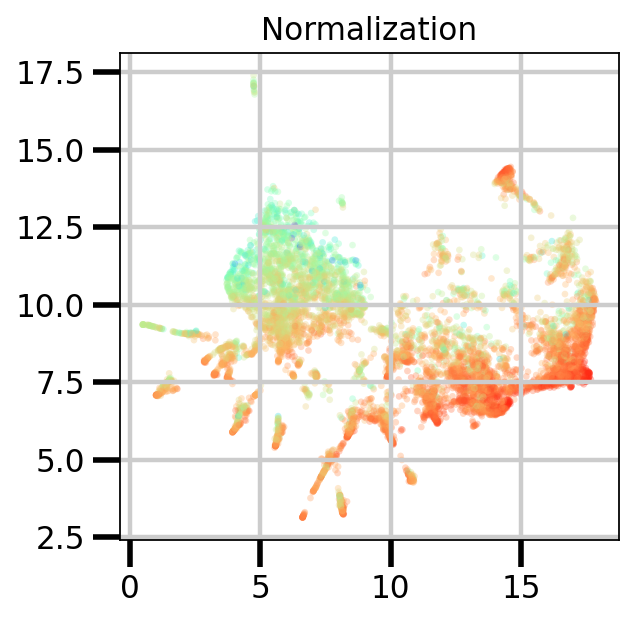

In [6]:
for i in range(24,25):
    figure, axes = plt.subplots(1,1)
    number_of_components = i
    pca1 = PCA(number_of_components)
    pca1.fit(scaled_data)
    pca_embedding = pca1.transform(scaled_data)
    reducer = umap.UMAP(n_components = 2)
    umap_embedding = reducer.fit_transform(pca_embedding)
    expression_count = np.sum(x.T,axis = 1)
    axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1,alpha = 0.3, c = np.log(expression_count), cmap = 'rainbow')

    axes.set_title('Normalization')
    figure.savefig(figure_path + 'genes_umap_expression_normed_campari_'+str(i)+'.png')

In [7]:
gene_name = []
for i in range(len(adata.var['gene_name'])):
    gene_name.append(adata.var['gene_name'].iloc[i])

    
marker_genes = ['Ntrk2','Cd34','Nppb','Mrgprb4','Mrgpra3','Mrgprd','Sstr2','Adra2a','Smr2',
                'Bmpr1b','Nefh','Pvalb','Adm',
                'Trpm3','Piezo2','Trpm2','Smr2','Sstr2','Bmpr1b','Trpm8','Trpv1','Piezo2','Piezo1','Nppb',
                'Sst','Pvalb','Prokr2','Mrgprd','Mrgpra3','Cd34',
                'Th','Trpa1','Ntrk3','Ntrk2','Ntrk1','Ret','Tac1','Calca','Calcb','Nefh',
                'S100b','Scn10a','Slc17a8','Atf3','Pou4f3','Calb1','Avil','Asic3',
                'Asic2','Asic1','Pou6f2','Avpr1a','Pou4f2','Sox10','Chrna7','Chrna3',
                'P2rx3','Gfra2','Ldhb','Necab2','Spp1','Adra2a','Chrna7','Tafa4']

marker_position = np.zeros((len(marker_genes),))
count = 0
for marker in  marker_genes:
    index = gene_name.index(marker)
    marker_position[count] = index
    count = count+1

n = 20
nearest_neighbors = np.zeros((n, len(marker_genes)))
nearest_neighbors_distance = np.zeros((n, len(marker_genes)))
auxiliar_distance = np.zeros((umap_embedding.shape[0]))

nearest_neighbors_cut = np.zeros((n, len(marker_genes)))
nearest_neighbors_distance_cut = np.zeros((n, len(marker_genes)))
auxiliar_distance_cut = np.zeros((umap_embedding.shape[0]))

for i in range(len(marker_genes)):
    a = umap_embedding[int(marker_position[i]),:]
    #a = x.T[int(marker_position[i]),:]
    for j in range(umap_embedding.shape[0]):
        b = umap_embedding[j,:]
        #b = x.T[j,:]
        dist = np.linalg.norm(a-b)
        auxiliar_distance[j] = dist
    sorted_arguments = np.argsort(auxiliar_distance)
    nearest_neighbors_distance[:,i] = auxiliar_distance[sorted_arguments[0:n]]
    nearest_neighbors[:,i] = sorted_arguments[0:n].astype(int)

    
closest_genes = []
for i in range(len(marker_genes)):
    closest_genes_ = []
    for j in range(n):
        closest_genes_.append(gene_name[int(nearest_neighbors[j,i])])
    closest_genes.append(closest_genes_)
 

In [52]:
#############################################################################################################
#############################################################################################################
#############################################################################################################
#################### HERE WE EXPORT ALL THE INFORMATION FOR GENES AS .MAT ################

data = {'umap_embedding_norm': umap_embedding,'genes': gene_name}
scipy.io.savemat(figure_path + 'genes_umap_1.mat', data)        

#############################################################################################################
#############################################################################################################
#############################################################################################################

9857.0